# Memory 1 Homogeneous Agents

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood

from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Utils import FlowPlot as fp

from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

## Introduction

In [62]:
socdi = SocialDilemma(R=1.0, T=1.2, S=-0.5, P=0.0)

In [63]:
memo1pd = HistoryEmbedded(socdi, h=(1,1,1))

In [64]:
mae1 = stratAC(env=memo1pd, learning_rates=0.01, discount_factors=0.9)

In [65]:
memo1pd.Sset

['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']

In [66]:
x = mae1.random_softmax_strategy

In [78]:
x

Array([[[0.881994  , 0.118006  ],
        [0.8286755 , 0.17132446],
        [0.74943393, 0.25056607],
        [0.96603066, 0.03396936]],

       [[0.23827028, 0.7617297 ],
        [0.78315604, 0.21684396],
        [0.8698325 , 0.13016747],
        [0.17598902, 0.82401097]]], dtype=float32)

In [67]:
timeseries, fpr = mae1.trajectory(x, Tmax=10000, tolerance=10e-6)
fpr

True

In [68]:
timeseries.shape

(2487, 2, 4, 2)

Text(0, 0.5, 'cooperation probability')

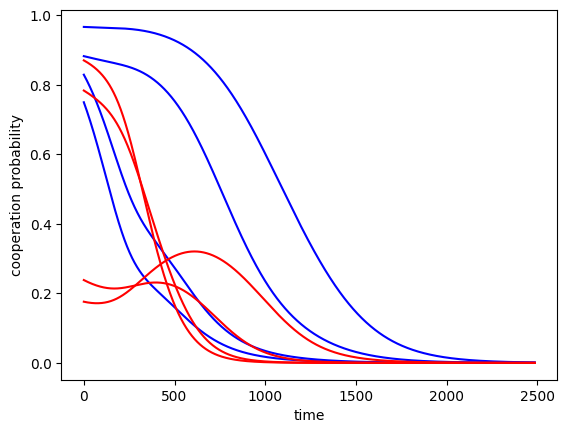

In [69]:
plt.plot(timeseries[:, 0, :, 0], color='blue', label='agent0')
plt.plot(timeseries[:, 1, :, 0], color='red', label='agent1')
plt.xlabel('time'); plt.ylabel('cooperation probability')

In [70]:
Rti = np.array([mae1.Ri(x) for x in timeseries])

In [80]:
Rti.shape

(2487, 2)

Text(0, 0.5, 'average reward')

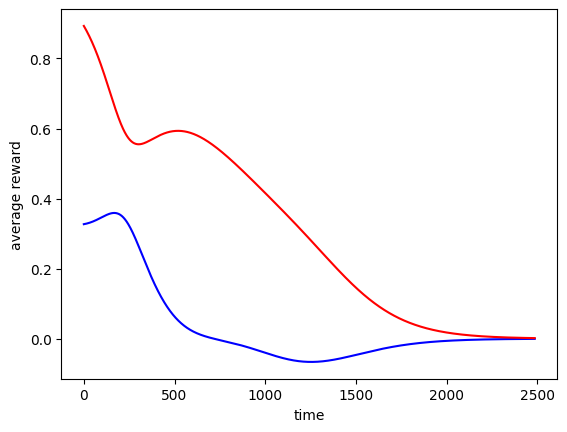

In [71]:
plt.plot(Rti[:, 0], color='blue', label='agent0')
plt.plot(Rti[:, 1], color='red', label='agent1')
plt.xlabel('time'); plt.ylabel('average reward')

In [72]:
Rti.shape

(2487, 2)

## 25 iterations

In [81]:
# Number of simulations to run
num_simulations = 25

# Initialize dictionaries to store the results
all_rewards = {'agent0': [], 'agent1': []}
all_trajectories = {'agent0': [], 'agent1': []}
all_convergence = {'agent0': [], 'agent1': []}

for _ in range(num_simulations):
    # Initialize the environment and agent as before
    socdi = SocialDilemma(R=1.0, T=1.2, S=-0.5, P=0.0)
    memo1pd = HistoryEmbedded(socdi, h=(1,1,1))

    mae1 = stratAC(env=memo1pd, learning_rates=0.01, discount_factors=0.9)
    x = mae1.random_softmax_strategy()

    # Get the trajectory and final probability distribution
    timeseries, fpr = mae1.trajectory(x, Tmax=10000, tolerance=10e-6)
    
    # Calculate rewards for each step in the trajectory
    Rti = np.array([mae1.Ri(x) for x in timeseries])

    # Store the results by agent and add fpr to each step
    all_rewards['agent0'].append(Rti[:, 0])
    all_rewards['agent1'].append(Rti[:, 1])
    all_trajectories['agent0'].append(timeseries[:, 0, :, 0])
    all_trajectories['agent1'].append(timeseries[:, 1, :, 0])

    # Append fpr status to each time step for both agents
    all_convergence['agent0'].append(np.full(timeseries.shape[0], fpr))
    all_convergence['agent1'].append(np.full(timeseries.shape[0], fpr))

# Convert lists to numpy object arrays for flexible handling
for agent in all_rewards:
    all_rewards[agent] = np.array(all_rewards[agent], dtype=object)
    all_trajectories[agent] = np.array(all_trajectories[agent], dtype=object)
    all_convergence[agent] = np.array(all_convergence[agent], dtype=object)

# Save each agent's data separately and the convergence information
for agent in ['agent0', 'agent1']:
    np.save(f'simulation_rewards_{agent}.npy', all_rewards[agent])
    np.save(f'simulation_trajectories_{agent}.npy', all_trajectories[agent])
    np.save(f'simulation_convergence_{agent}.npy', all_convergence[agent])


In [73]:
def load_simulation_data():
    agents = ['agent0', 'agent1']
    loaded_rewards = {}
    loaded_trajectories = {}
    loaded_convergence = {}

    for agent in agents:
        loaded_rewards[agent] = np.load(f'simulation_rewards_{agent}.npy', allow_pickle=True)
        loaded_trajectories[agent] = np.load(f'simulation_trajectories_{agent}.npy', allow_pickle=True)
        loaded_convergence[agent] = np.load(f'simulation_convergence_{agent}.npy', allow_pickle=True)

        # Print some information to confirm loading
        print(f"{agent} - Rewards data shape:", loaded_rewards[agent].shape)
        print(f"{agent} - Trajectories data shape:", loaded_trajectories[agent].shape)
        print(f"{agent} - Convergence data shape:", loaded_convergence[agent].shape)

    return loaded_rewards, loaded_trajectories, loaded_convergence

# Call the function to load data
rewards, trajectories, convergence = load_simulation_data()


agent0 - Rewards data shape: (25,)
agent0 - Trajectories data shape: (25,)
agent0 - Convergence data shape: (25,)
agent1 - Rewards data shape: (25,)
agent1 - Trajectories data shape: (25,)
agent1 - Convergence data shape: (25,)


In [27]:
def find_false_position(arr):
    # Use np.where to find the indices of False values in the array
    false_indices = np.where(arr == False)[0]  # [0] to get the indices from the tuple returned by np.where
    
    if false_indices.size > 0:
        return false_indices[0]  # Return the first index where False is found
    else:
        return None  # Return None if no False value is found

# Example usage
example_array = convergence
first_false_position = find_false_position(example_array)
print("First False position:", first_false_position)


First False position: None


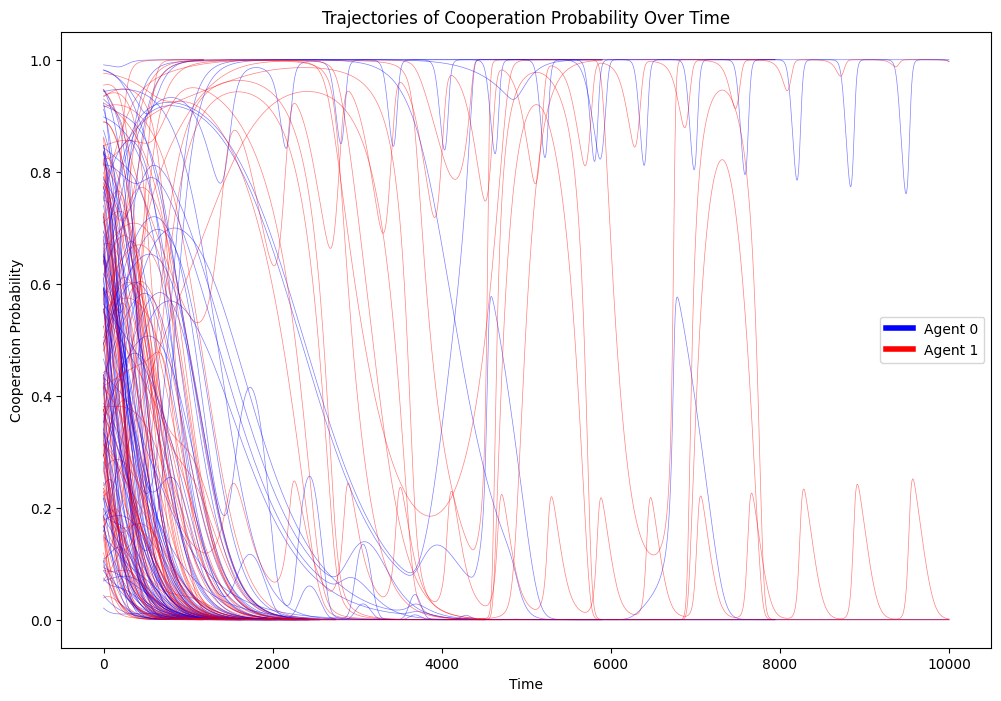

In [28]:
# Setup plot
plt.figure(figsize=(12, 8))  # Larger figure size

# Define colors for clarity and reusability
colors = {'Agent 0': 'blue', 'Agent 1': 'red'}

# Loop through each simulation
for i in range(len(trajectories['agent0'])):
    # Plot each trajectory for agent 0
    plt.plot(trajectories['agent0'][i], color=colors['Agent 0'], alpha=0.5, linewidth=0.5)
    # Plot each trajectory for agent 1
    plt.plot(trajectories['agent1'][i], color=colors['Agent 1'], alpha=0.5, linewidth=0.5)

plt.xlabel('Time')
plt.ylabel('Cooperation Probability')
plt.title('Trajectories of Cooperation Probability Over Time')

# Create custom handles for the legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors['Agent 0'], lw=4),
                Line2D([0], [0], color=colors['Agent 1'], lw=4)]

# Set the legend with custom handles
plt.legend(custom_lines, ['Agent 0', 'Agent 1'])

plt.show()

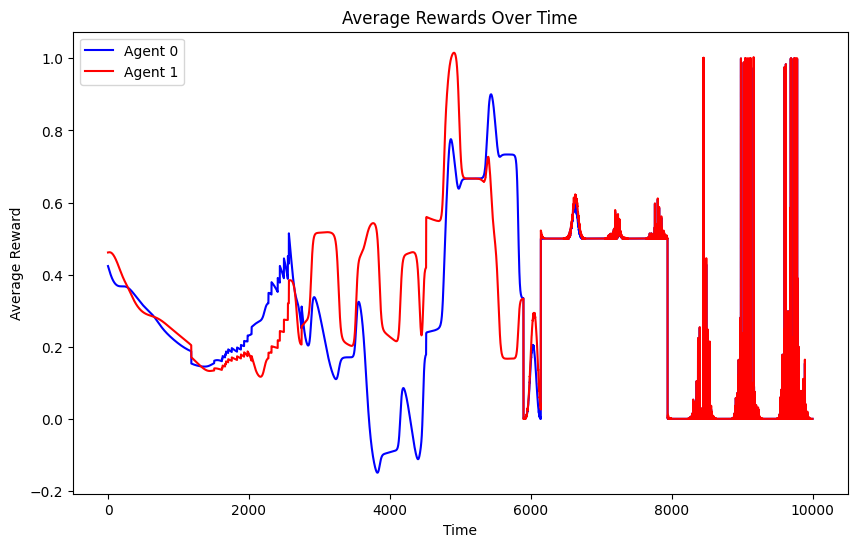

In [29]:
def pad_rewards(rewards):
    max_length = max(len(r) for r in rewards)  # Find the longest array
    return np.array([np.pad(r, (0, max_length - len(r)), 'constant', constant_values=np.nan) for r in rewards])

# Pad rewards to the longest length
padded_rewards_agent0 = pad_rewards(rewards['agent0'])
padded_rewards_agent1 = pad_rewards(rewards['agent1'])

# Calculate average rewards ignoring NaNs
average_rewards_agent0 = np.nanmean(padded_rewards_agent0, axis=0)
average_rewards_agent1 = np.nanmean(padded_rewards_agent1, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(average_rewards_agent0, label='Agent 0', color='blue')
plt.plot(average_rewards_agent1, label='Agent 1', color='red')
plt.title('Average Rewards Over Time')
plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.legend()
plt.show()


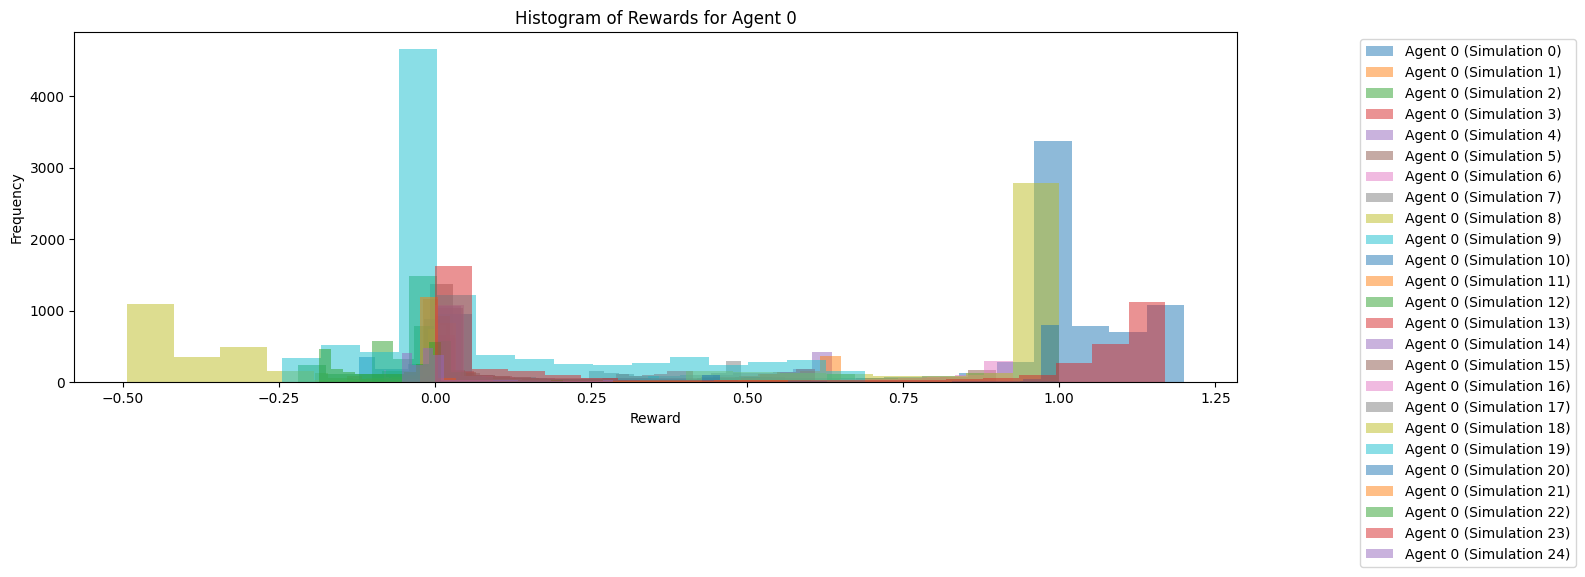

In [32]:
# Get the rewards for each agent
rewards_agent0 = rewards['agent0']
rewards_agent1 = rewards['agent1']

# Plot the histograms
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for i, reward in enumerate(rewards_agent0):
    plt.hist(reward, bins=20, alpha=0.5, label=f'Agent 0 (Simulation {i})', color=f'C{i}')
plt.title('Histogram of Rewards for Agent 0')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0))  # Move the legend to the upper right

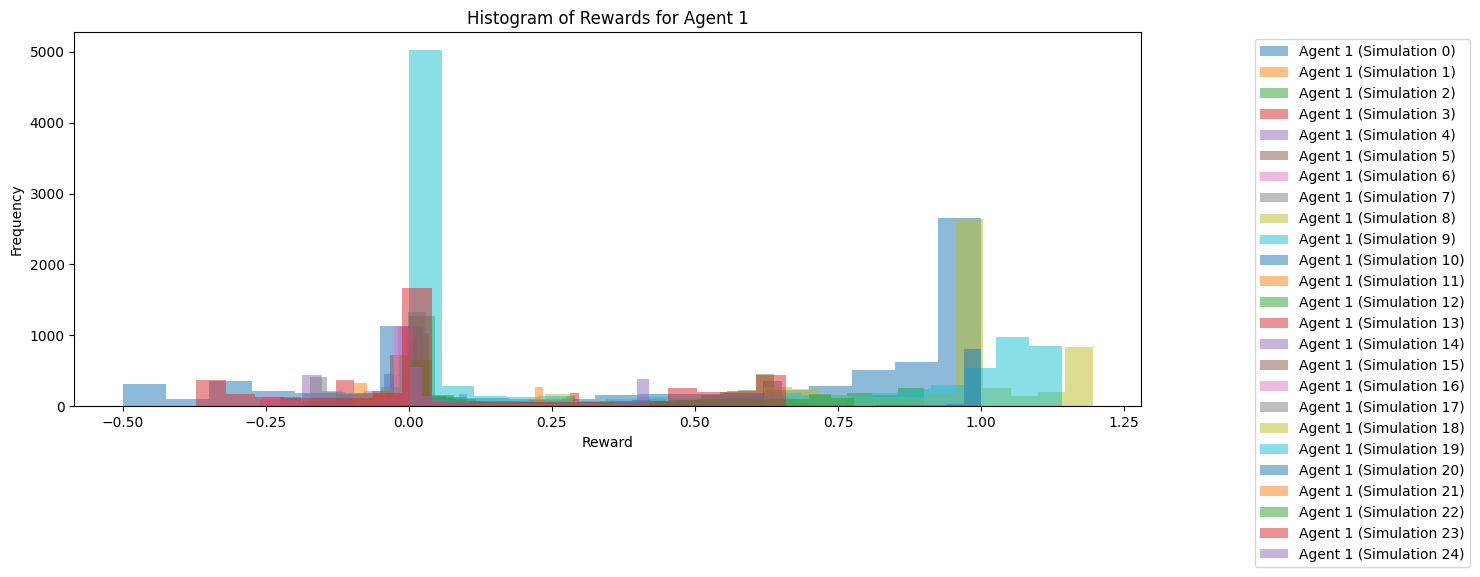

In [33]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)
for i, reward in enumerate(rewards_agent1):
    plt.hist(reward, bins=20, alpha=0.5, label=f'Agent 1 (Simulation {i})', color=f'C{i}')
plt.title('Histogram of Rewards for Agent 1')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0))  # Move the legend to the right

plt.tight_layout()
plt.show()

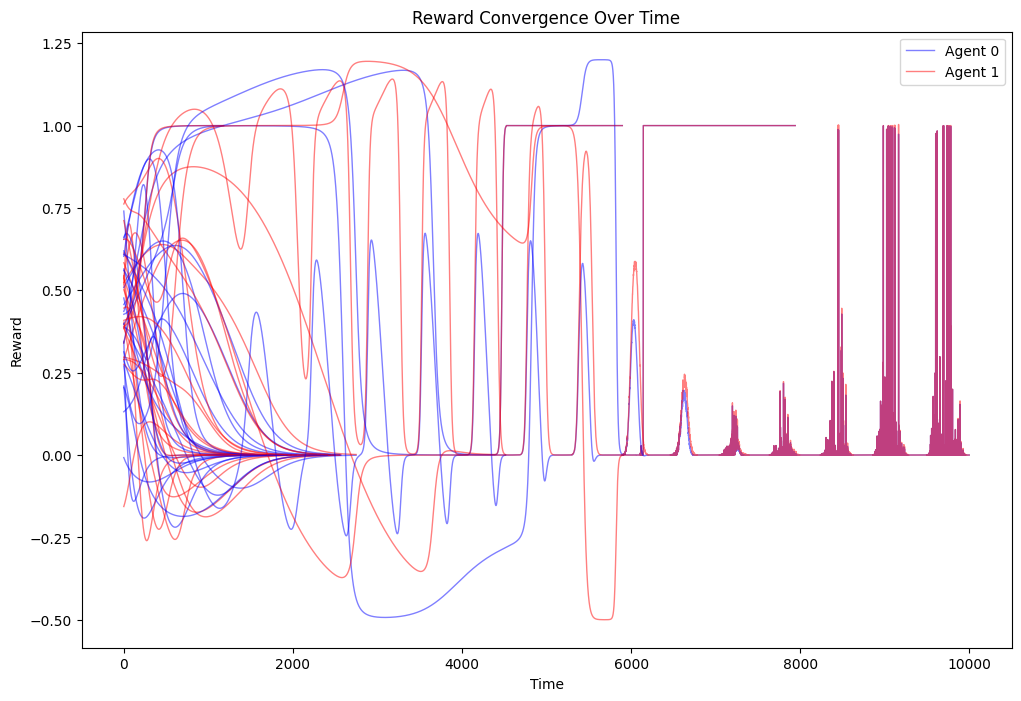

In [34]:
plt.figure(figsize=(12, 8))
for i in range(len(rewards['agent0'])):
    plt.plot(rewards['agent0'][i], color='blue', alpha=0.5, linewidth=1, label='Agent 0' if i == 0 else "")
    plt.plot(rewards['agent1'][i], color='red', alpha=0.5, linewidth=1, label='Agent 1' if i == 0 else "")
plt.title('Reward Convergence Over Time')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.legend()
plt.show()


In [46]:
trajectories['agent0'][0].shape

(2567, 4)

In [41]:
trajectories['agent0'].shape

(25,)

### Thinking in games

- High cooperation probabilities with high rewards could imply mutual cooperation (CC).
- Low cooperation probabilities with low rewards might suggest mutual defection (DD).
- High cooperation probabilities for one agent and low rewards for the other could suggest exploitation, where one cooperates (C) and the other defects (D), resulting in CD or DC scenarios.

#### Joint strategy solution

In [221]:
def is_within_tolerance(value, target, tolerance):
    return abs(value - target) <= tolerance

def infer_agent_actions(rewards_agent0, rewards_agent1, R, T, S, P, tolerance):
    # Calculate the average payoff for the game based on the defined rewards
    average_payoff = (R + T + S + P) / 4

    # CC: Check whether both agents (mostly) cooperated
    if is_within_tolerance(rewards_agent0, R, tolerance) and  is_within_tolerance(rewards_agent1, R, tolerance):
        return 'C', 'C'
    # DD: Check whether both agents (mostly) defected
    elif is_within_tolerance(rewards_agent0, P, tolerance) and is_within_tolerance(rewards_agent1, P, tolerance):
        return 'D', 'D'
    # DC: Check whether a0 exploited a1
    elif is_within_tolerance(rewards_agent0, T, tolerance) or is_within_tolerance(rewards_agent0, R, tolerance) and is_within_tolerance(rewards_agent1, S, tolerance):
        return 'D', 'C'
    # CD: Check whether a1 exploited a0
    elif is_within_tolerance(rewards_agent1, T, tolerance) or is_within_tolerance(rewards_agent1, R, tolerance) and is_within_tolerance(rewards_agent0, S, tolerance):
        return 'C', 'D'
    # Ambiguous cases, cannot determine action
    elif is_within_tolerance(rewards_agent0, average_payoff, tolerance) or is_within_tolerance(rewards_agent1, average_payoff, tolerance):
        return None
    else:
        # If reward is not within tolerance of any payoff, action is undetermined
        return None
    
# Initialize lists to hold inferred actions
inferred_actions_agent0 = []
inferred_actions_agent1 = []

tolerance = 0.4

rewards_mean_agent0 = []
rewards_mean_agent1 = []

for i in range(len(rewards['agent0'])):
    rewards_mean_agent0.append(rewards['agent0'][i].mean())
    rewards_mean_agent1.append(rewards['agent1'][i].mean())

# Iterate over each reward and infer actions for both agents
for reward0, reward1 in zip(rewards_mean_agent0, rewards_mean_agent1):
    actions = infer_agent_actions(reward0, reward1, R=1.0, T=1.2, S=-0.5, P=0.0, tolerance=tolerance)
    if actions is None:
        inferred_actions_agent0.append(None)
        inferred_actions_agent1.append(None)
    else:
        inferred_actions_agent0.append(actions[0])
        inferred_actions_agent1.append(actions[1])

# Output the results
for i in range(len(inferred_actions_agent0)):
    print(f"Game {i}: Agent0 likely average action: {inferred_actions_agent0[i]}, Agent1 likely average action: {inferred_actions_agent1[i]}")

Game 0: Agent0 likely average action: D, Agent1 likely average action: D
Game 1: Agent0 likely average action: D, Agent1 likely average action: D
Game 2: Agent0 likely average action: D, Agent1 likely average action: D
Game 3: Agent0 likely average action: D, Agent1 likely average action: D
Game 4: Agent0 likely average action: D, Agent1 likely average action: D
Game 5: Agent0 likely average action: D, Agent1 likely average action: D
Game 6: Agent0 likely average action: D, Agent1 likely average action: D
Game 7: Agent0 likely average action: D, Agent1 likely average action: D
Game 8: Agent0 likely average action: D, Agent1 likely average action: D
Game 9: Agent0 likely average action: D, Agent1 likely average action: D
Game 10: Agent0 likely average action: D, Agent1 likely average action: C
Game 11: Agent0 likely average action: D, Agent1 likely average action: D
Game 12: Agent0 likely average action: D, Agent1 likely average action: D
Game 13: Agent0 likely average action: D, Agent1

#### Sanity example: Exploitation and sucker

To me this seems like a typical case of explotation agent 0 and sucker agent 1.

R=1.0, T=1.2, S=-0.5, P=0.0

In [142]:
rewards['agent0'][10].mean()

0.8770281

In [143]:
rewards['agent1'][10].mean()

0.50151676

Text(0, 0.5, 'average reward')

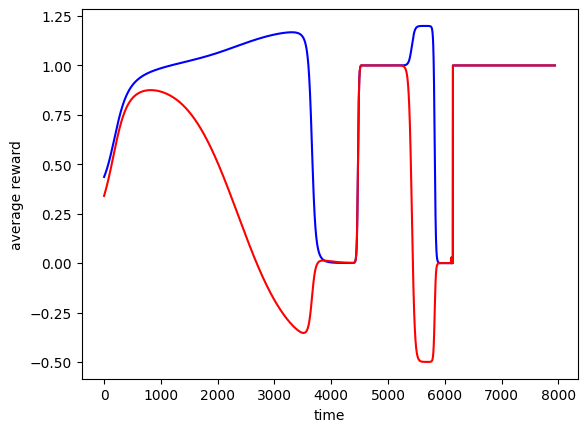

In [141]:
plt.plot(rewards['agent0'][10], color='blue', label='agent0')
plt.plot(rewards['agent1'][10], color='red', label='agent1')
plt.xlabel('time'); plt.ylabel('average reward')

The code above seems to respond to this. In the line for game 10 we have:

Game 10: Agent0 likely average action: D, Agent1 likely average action: C

#### Separate strategy solution

The previous solution uses the `Ri` method:

```python
def Ri(
    self: abase, Xisa: jnp.ndarray  # Joint strategy `Xisa`
) -> jnp.ndarray:  # Average reward `Ri`
    """Compute average reward `Ri`, given joint strategy `Xisa`."""
    i, s = 0, 1
    return jnp.einsum(self.Ps(Xisa), [s], self.Ris(Xisa), [i, s], [i])
```

And we get the average result of these games. We could get a much more fine grained result if instead we'd calculate the reward for each set of game.
So following the same logic as above if we have the first game CC and one agent got a reward close to 1.2 (T) and another one close to -0.5 (S), that means the exploitation algorithm was used here.

This approach improves precision and it might also be easier to code in larger history scenarios. I just need to rewrite the Ri function so it doesn't `einsum` over everything and concatenates things.

## 500 iterations

In [83]:
# The following cell is commented out because the data was already extracted and this is not
# something you usually want to run by mistake!

In [237]:
# from tqdm import tqdm  # Import tqdm

# # Number of simulations to run
# num_simulations = 500

# # Initialize dictionaries to store the results
# all_rewards = {'agent0': [], 'agent1': []}
# all_trajectories = {'agent0': [], 'agent1': []}
# all_convergence = {'agent0': [], 'agent1': []}

# # Loop over the number of simulations with a progress bar
# for _ in tqdm(range(num_simulations), desc="Running simulations"):
#     # Initialize the environment and agent as before
#     socdi = SocialDilemma(R=1.0, T=1.2, S=-0.5, P=0.0)
#     memo1pd = HistoryEmbedded(socdi, h=(1,1,1))

#     mae1 = stratAC(env=memo1pd, learning_rates=0.01, discount_factors=0.9)
#     x = mae1.random_softmax_strategy()

#     # Get the trajectory and final probability distribution
#     timeseries, fpr = mae1.trajectory(x, Tmax=10000, tolerance=10e-6)
    
#     # Calculate rewards for each step in the trajectory
#     Rti = np.array([mae1.Ri(x) for x in timeseries])

#     # Store the results by agent and add fpr to each step
#     all_rewards['agent0'].append(Rti[:, 0])
#     all_rewards['agent1'].append(Rti[:, 1])
#     all_trajectories['agent0'].append(timeseries[:, 0, :, 0])
#     all_trajectories['agent1'].append(timeseries[:, 1, :, 0])

#     # Append fpr status to each time step for both agents
#     all_convergence['agent0'].append(np.full(timeseries.shape[0], fpr))
#     all_convergence['agent1'].append(np.full(timeseries.shape[0], fpr))

# # Convert lists to numpy object arrays for flexible handling
# for agent in all_rewards:
#     all_rewards[agent] = np.array(all_rewards[agent], dtype=object)
#     all_trajectories[agent] = np.array(all_trajectories[agent], dtype=object)
#     all_convergence[agent] = np.array(all_convergence[agent], dtype=object)

# # Save each agent's data separately and the convergence information
# for agent in ['agent0', 'agent1']:
#     np.save(f'simulation_rewards_500{agent}.npy', all_rewards[agent])
#     np.save(f'simulation_trajectories_500{agent}.npy', all_trajectories[agent])
#     np.save(f'simulation_convergence_500{agent}.npy', all_convergence[agent])


Running simulations: 100%|███████████████████████████████████████████| 500/500 [08:43<00:00,  1.05s/it]


In [53]:
def load_simulation_data():
    agents = ['agent0', 'agent1']
    loaded_rewards = {}
    loaded_trajectories = {}
    loaded_convergence = {}

    for agent in agents:
        loaded_rewards[agent] = np.load(f'simulation_rewards_500{agent}.npy', allow_pickle=True)
        loaded_trajectories[agent] = np.load(f'simulation_trajectories_500{agent}.npy', allow_pickle=True)
        loaded_convergence[agent] = np.load(f'simulation_convergence_500{agent}.npy', allow_pickle=True)

        # Print some information to confirm loading
        print(f"{agent} - Rewards data shape:", loaded_rewards[agent].shape)
        print(f"{agent} - Trajectories data shape:", loaded_trajectories[agent].shape)
        print(f"{agent} - Convergence data shape:", loaded_convergence[agent].shape)

    return loaded_rewards, loaded_trajectories, loaded_convergence

# Call the function to load data
rewards, trajectories, convergence = load_simulation_data()

agent0 - Rewards data shape: (500,)
agent0 - Trajectories data shape: (500,)
agent0 - Convergence data shape: (500,)
agent1 - Rewards data shape: (500,)
agent1 - Trajectories data shape: (500,)
agent1 - Convergence data shape: (500,)


/Users/mariana/.pyenv/versions/3.10.3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



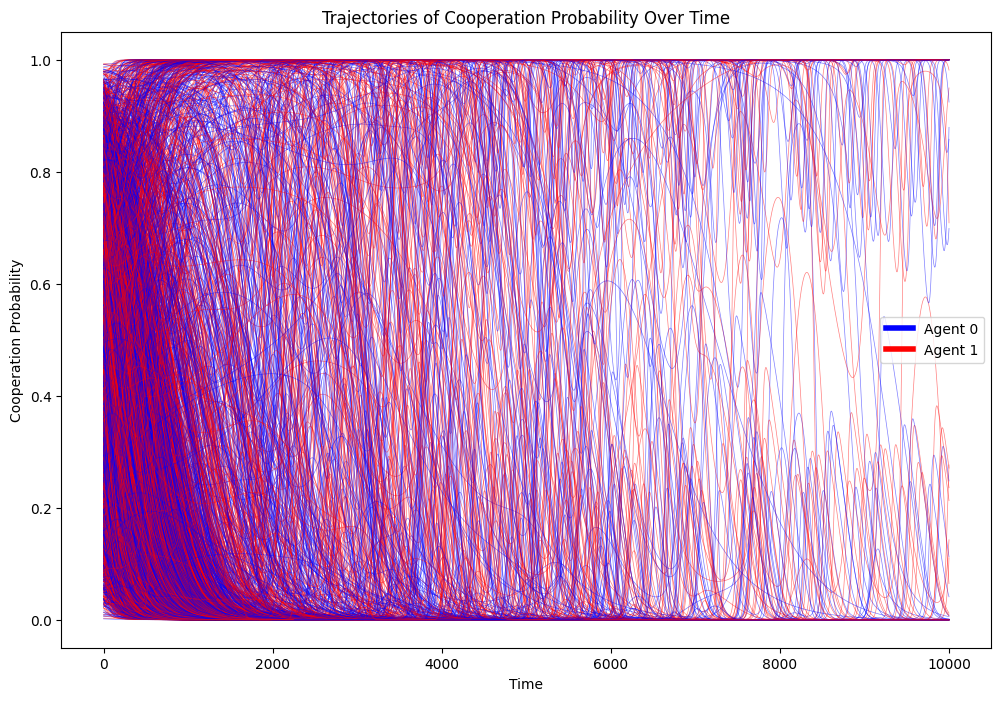

In [239]:
# Setup plot
plt.figure(figsize=(12, 8))  # Larger figure size

# Define colors for clarity and reusability
colors = {'Agent 0': 'blue', 'Agent 1': 'red'}

# Loop through each simulation
for i in range(len(trajectories['agent0'])):
    # Plot each trajectory for agent 0
    plt.plot(trajectories['agent0'][i], color=colors['Agent 0'], alpha=0.5, linewidth=0.5)
    # Plot each trajectory for agent 1
    plt.plot(trajectories['agent1'][i], color=colors['Agent 1'], alpha=0.5, linewidth=0.5)

plt.xlabel('Time')
plt.ylabel('Cooperation Probability')
plt.title('Trajectories of Cooperation Probability Over Time')

# Create custom handles for the legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors['Agent 0'], lw=4),
                Line2D([0], [0], color=colors['Agent 1'], lw=4)]

# Set the legend with custom handles
plt.legend(custom_lines, ['Agent 0', 'Agent 1'])

plt.show()